## Analyze transcript-specific fold changes in different studies

## Load libraries

In [1]:
suppressPackageStartupMessages({
  # library(DESeq2)
  library(tidyverse)
  library(plyranges)
  library(rasilabRtemplates)
})

options(repr.matrix.max.rows = 10, warn = -1)

count_cutoff <- 1000

gene_subset <- c("FOS", "JUN", "ATF3", "EGR1", "DUSP1", "IER2", "MYC", "GPR50", "ADAMST1", "RHOB", "TIMP3", "JUND")

theme_set(theme_rasilab() +
  theme(
    axis.line = element_line(color = "grey"),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.title.x = element_text(margin = margin(t = 10))
  ))


Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”


## Read sample annotations

In [ ]:
sample_annotations <- read_csv("../../20231211_i202_splicing_factor_hits/annotations/sample_annotations.csv", show_col_types = F) %>%
  filter(str_detect(sample_id, "^220")) %>%
  print()

# A tibble: 12 × 8
   user  sample_name      sample_id map     index_primer study average…¹ plasmid
   <chr> <chr>            <chr>     <chr>   <chr>        <chr>     <dbl> <chr>  
 1 pn    gcn1_1_2_rep1_0h 220p11    lpnhs25 oas112       i189        300 pHPHS2…
 2 pn    gcn1_1_2_rep2_0h 220p12    lpnhs25 oas113       i189        300 pHPHS2…
 3 pn    gcn1_3_4_rep1_0h 220p13    lpnhs25 oas114       i189        300 pHPHS2…
 4 pn    gcn1_3_4_rep2_0h 220p14    lpnhs25 oas115       i189        300 pHPHS2…
 5 pn    fluc_1_2_rep1_0h 220p15    lpnhs25 oas116       i189        300 pHPHS2…
 6 pn    fluc_1_2_rep2_0h 220p16    lpnhs25 oas117       i189        300 pHPHS2…
 7 pn    gcn1_3_4_rep1_6h 220p19    lpnhs25 oas130       i189        300 pHPHS2…
 8 pn    gcn1_3_4_rep2_6h 220p20    lpnhs25 oas131       i189        300 pHPHS2…
 9 pn    fluc_1_2_rep1_6h 220p21    lpnhs25 oas132       i189        300 pHPHS2…
10 pn    fluc_1_2_rep2_6h 220p22    lpnhs25 oas133       i189        300 pHPHS2…
11 pn    

## Read gene annotations

In [ ]:
gene_annotations <- read_gff2("../../20231211_i202_splicing_factor_hits/data/ensembl/Homo_sapiens.GRCh38.108.genes.gtf") %>%
  as_tibble() %>%
  filter(gene_biotype == "protein_coding") %>%
  print()

# A tibble: 19,967 × 14
   seqnames  start    end  width strand source type  score phase gene_id gene_…¹
   <fct>     <int>  <int>  <int> <fct>  <fct>  <fct> <dbl> <int> <chr>   <chr>  
 1 1        1.47e6 1.50e6  26084 +      ensem… gene     NA    NA ENSG00… 20     
 2 1        3.07e6 3.44e6 369454 +      ensem… gene     NA    NA ENSG00… 17     
 3 1        2.40e6 2.41e6   9834 -      ensem… gene     NA    NA ENSG00… 11     
 4 1        1.05e7 1.06e7 158471 +      ensem… gene     NA    NA ENSG00… 13     
 5 1        2.43e6 2.51e6  79553 +      ensem… gene     NA    NA ENSG00… 18     
 6 1        9.29e6 9.37e6  76639 +      ensem… gene     NA    NA ENSG00… 14     
 7 1        6.16e6 6.20e6  38328 -      havana gene     NA    NA ENSG00… 1      
 8 1        6.24e6 6.25e6   1400 +      ensem… gene     NA    NA ENSG00… 8      
 9 1        9.04e6 9.09e6  53373 -      ensem… gene     NA    NA ENSG00… 18     
10 1        1.57e7 1.57e7  50450 +      ensem… gene     NA    NA ENSG00… 13     
# … 

## Read in gene count data

In [ ]:
count_data <- "../../20231211_i202_splicing_factor_hits/data/alignments/" %>% 
  list.files(full.names = T, pattern = "ReadsPerGene.out.tab", recursive = T) %>% 
  as_tibble_col("file") %>% 
  filter(str_detect(file, "genome_220")) %>%
  mutate(sample_id = str_extract(file, "220p[:digit:]+")) %>%
  mutate(data = map(file, ~read_tsv(.x, show_col_types = F, col_names = c("gene_id", "total", "fwd", "rev")))) %>% 
  select(-file) %>%
  unnest(data) %>%
  select(-total, -fwd) %>%
  filter(str_detect(gene_id, "^ENSG")) %>%
  print()

# A tibble: 745,152 × 3
   sample_id gene_id           rev
   <chr>     <chr>           <dbl>
 1 220p11    ENSG00000160072   585
 2 220p11    ENSG00000279928     0
 3 220p11    ENSG00000228037     0
 4 220p11    ENSG00000142611    92
 5 220p11    ENSG00000284616     0
 6 220p11    ENSG00000157911   301
 7 220p11    ENSG00000269896     9
 8 220p11    ENSG00000228463     2
 9 220p11    ENSG00000260972     0
10 220p11    ENSG00000224340     0
# … with 745,142 more rows


## Subset to transcripts that get summed counts across conditions greater than count cutoff

In [ ]:
count_data_above_cutoff <- count_data %>% 
  group_by(gene_id) %>% 
  mutate(total_study_counts = sum(rev)) %>% 
  ungroup() %>% 
  filter(total_study_counts >= count_cutoff) %>% 
  select(-total_study_counts) %>% 
  # separate(gene_id, c("gene_id", "gene_name"), sep = "\\|") %>% 
  print()

# A tibble: 124,080 × 3
   sample_id gene_id           rev
   <chr>     <chr>           <dbl>
 1 220p11    ENSG00000160072   585
 2 220p11    ENSG00000142611    92
 3 220p11    ENSG00000157911   301
 4 220p11    ENSG00000142655   248
 5 220p11    ENSG00000116786   743
 6 220p11    ENSG00000037637   450
 7 220p11    ENSG00000159423   181
 8 220p11    ENSG00000011021   213
 9 220p11    ENSG00000157916   748
10 220p11    ENSG00000157881   332
# … with 124,070 more rows


## Count data for GCN1-Harringtonine experiment

In [ ]:
count_data <- count_data_above_cutoff %>% 
  left_join(sample_annotations %>% select(sample_id, sample_name), by = "sample_id") %>%
  select(-sample_id) %>%
  pivot_wider(values_from = "rev", names_from = "sample_name") %>% 
  column_to_rownames("gene_id") 


head(count_data)

,gcn1_1_2_rep1_0h,gcn1_1_2_rep2_0h,gcn1_3_4_rep1_0h,gcn1_3_4_rep2_0h,fluc_1_2_rep1_0h,fluc_1_2_rep2_0h,gcn1_1_2_rep1_6h,gcn1_1_2_rep2_6h,gcn1_3_4_rep1_6h,gcn1_3_4_rep2_6h,fluc_1_2_rep1_6h,fluc_1_2_rep2_6h
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000160072,585,675,712,733,739,756,1380,1362,1081,1026,1311,1109
ENSG00000142611,92,116,153,125,123,141,148,156,152,120,202,187
ENSG00000157911,301,205,315,334,331,326,427,422,358,362,497,482
ENSG00000142655,248,251,315,333,260,264,434,459,316,348,384,326
ENSG00000116786,743,729,806,839,718,772,1102,1195,954,892,835,694
ENSG00000037637,450,331,450,442,449,462,664,610,536,511,712,598


## Col data for GCN1-Harringtonine experiment


In [ ]:
col_data <- colnames(count_data) %>% 
  as_tibble_col("sample_name") %>% 
  separate(sample_name, c("ko", "sgrna1", "sgrna2", "rep", "time"), remove=F) %>%
  unite(sample, ko, sgrna1, sgrna2, time, sep = "_") %>%
  column_to_rownames("sample_name") %>%
  print()

                      sample  rep
gcn1_1_2_rep1_0h gcn1_1_2_0h rep1
gcn1_1_2_rep2_0h gcn1_1_2_0h rep2
gcn1_3_4_rep1_0h gcn1_3_4_0h rep1
gcn1_3_4_rep2_0h gcn1_3_4_0h rep2
fluc_1_2_rep1_0h fluc_1_2_0h rep1
fluc_1_2_rep2_0h fluc_1_2_0h rep2
gcn1_1_2_rep1_6h gcn1_1_2_6h rep1
gcn1_1_2_rep2_6h gcn1_1_2_6h rep2
gcn1_3_4_rep1_6h gcn1_3_4_6h rep1
gcn1_3_4_rep2_6h gcn1_3_4_6h rep2
fluc_1_2_rep1_6h fluc_1_2_6h rep1
fluc_1_2_rep2_6h fluc_1_2_6h rep2


## Run DESeq2 for GCN1-Harringtonine experiment


In [ ]:
dds <- DESeqDataSetFromMatrix(countData = count_data, colData = col_data, design = ~ sample)
dds <- DESeq(dds)

converting counts to integer mode



estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## Get DESeq2 results for GCN1-Harringtonine experiment

In [ ]:
resultsNames(dds)

[1] "Intercept"                         "sample_fluc_1_2_6h_vs_fluc_1_2_0h"
[3] "sample_gcn1_1_2_0h_vs_fluc_1_2_0h" "sample_gcn1_1_2_6h_vs_fluc_1_2_0h"
[5] "sample_gcn1_3_4_0h_vs_fluc_1_2_0h" "sample_gcn1_3_4_6h_vs_fluc_1_2_0h"

## Write sgFLUC fold changes upon Harringtonine treatment to file

In [ ]:
results(dds, 
    contrast = c("sample", "fluc_1_2_6h", "fluc_1_2_0h")) %>%
  as.data.frame() %>% 
  dplyr::rename(lfc = log2FoldChange) %>%
  mutate(across(baseMean:pvalue, . %>% round(3))) %>% 
  arrange(-lfc) %>%
  rownames_to_column("gene_id") %>%
  as_tibble() %>%
  inner_join(gene_annotations %>% select(gene_id, gene_name), by = "gene_id") %>%
  write_csv("../tables/sgfluc_1_2.6hvs0h.deseq2.csv") %>%
  print()

# A tibble: 9,926 × 8
   gene_id         baseMean   lfc lfcSE  stat pvalue      padj gene_name
   <chr>              <dbl> <dbl> <dbl> <dbl>  <dbl>     <dbl> <chr>    
 1 ENSG00000265972   1269.   2.95 0.16  18.5       0 6.20e- 73 TXNIP    
 2 ENSG00000163659   1002.   2.84 0.319  8.89      0 3.94e- 17 TIPARP   
 3 ENSG00000110031     94.6  2.73 0.297  9.18      0 3.14e- 18 LPXN     
 4 ENSG00000155090    811.   2.70 0.148 18.3       0 3.70e- 71 KLF10    
 5 ENSG00000114315   1954.   2.69 0.124 21.8       0 3.59e-101 HES1     
 6 ENSG00000277149    136.   2.58 0.262  9.85      0 6.32e- 21 TYW1B    
 7 ENSG00000083817    144.   2.56 0.253 10.1       0 6.01e- 22 ZNF416   
 8 ENSG00000204947    169.   2.47 0.23  10.7       0 9.89e- 25 ZNF425   
 9 ENSG00000170631    179.   2.43 0.232 10.5       0 1.13e- 23 ZNF16    
10 ENSG00000180573    438.   2.42 0.23  10.5       0 8.02e- 24 H2AC6    
# … with 9,916 more rows


## Write sgGCN1_1_2 fold changes upon Harringtonine treatment to file

In [ ]:
results(dds, 
    contrast = c("sample", "gcn1_1_2_6h", "gcn1_1_2_0h")) %>%
  as.data.frame() %>% 
  dplyr::rename(lfc = log2FoldChange) %>%
  mutate(across(baseMean:pvalue, . %>% round(3))) %>% 
  arrange(-lfc) %>%
  rownames_to_column("gene_id") %>%
  as_tibble() %>%
  inner_join(gene_annotations %>% select(gene_id, gene_name), by = "gene_id") %>%
  write_csv("../tables/sggcn1_1_2.6hvs0h.deseq2.csv") %>%
  print()

# A tibble: 9,926 × 8
   gene_id         baseMean   lfc lfcSE  stat pvalue      padj gene_name
   <chr>              <dbl> <dbl> <dbl> <dbl>  <dbl>     <dbl> <chr>    
 1 ENSG00000120738    7360.  7.56 0.183 41.2       0 0         EGR1     
 2 ENSG00000170345     791.  6.20 0.252 24.6       0 3.04e-130 FOS      
 3 ENSG00000120129    3808.  5.14 0.125 41.1       0 0         DUSP1    
 4 ENSG00000162772    6515.  5.12 0.119 43.1       0 0         ATF3     
 5 ENSG00000160888    6846.  4.96 0.161 30.8       0 5.57e-205 IER2     
 6 ENSG00000177606   23358.  4.66 0.147 31.7       0 1.94e-217 JUN      
 7 ENSG00000184545     492.  3.58 0.417  8.59      0 3.74e- 16 DUSP8    
 8 ENSG00000143507     120.  3.57 0.33  10.8       0 3.71e- 25 DUSP10   
 9 ENSG00000100604     102.  3.43 0.337 10.2       0 2.11e- 22 CHGA     
10 ENSG00000277149     136.  3.2  0.296 10.8       0 3.77e- 25 TYW1B    
# … with 9,916 more rows


## Write sgGCN1_3_4 fold changes upon Harringtonine treatment to file

In [ ]:
results(dds, 
    contrast = c("sample", "gcn1_3_4_6h", "gcn1_3_4_0h")) %>%
  as.data.frame() %>% 
  dplyr::rename(lfc = log2FoldChange) %>%
  mutate(across(baseMean:pvalue, . %>% round(3))) %>% 
  arrange(-lfc) %>%
  rownames_to_column("gene_id") %>%
  as_tibble() %>%
  inner_join(gene_annotations %>% select(gene_id, gene_name), by = "gene_id") %>%
  write_csv("../tables/sggcn1_3_4.6hvs0h.deseq2.csv") %>%
  print()

# A tibble: 9,926 × 8
   gene_id         baseMean   lfc lfcSE  stat pvalue      padj gene_name
   <chr>              <dbl> <dbl> <dbl> <dbl>  <dbl>     <dbl> <chr>    
 1 ENSG00000120738    7360.  7.87 0.183 43.0       0 0         EGR1     
 2 ENSG00000170345     791.  6.16 0.222 27.7       0 8.00e-166 FOS      
 3 ENSG00000162772    6515.  5.40 0.117 46.1       0 0         ATF3     
 4 ENSG00000160888    6846.  5.30 0.161 33.0       0 4.30e-235 IER2     
 5 ENSG00000120129    3808.  5.06 0.117 43.1       0 0         DUSP1    
 6 ENSG00000177606   23358.  4.78 0.147 32.6       0 4.77e-230 JUN      
 7 ENSG00000180573     438.  3.95 0.242 16.3       0 3.18e- 57 H2AC6    
 8 ENSG00000184545     492.  3.86 0.418  9.24      0 1.23e- 18 DUSP8    
 9 ENSG00000130522    2174.  3.51 0.298 11.8       0 9.06e- 30 JUND     
10 ENSG00000143507     120.  3.47 0.295 11.8       0 8.93e- 30 DUSP10   
# … with 9,916 more rows


## Write sgGCN1_1_2/sgFLuc fold changes at time 0 to file

In [ ]:
results(dds, 
    contrast = c("sample", "gcn1_1_2_0h", "fluc_1_2_0h")) %>%
  as.data.frame() %>% 
  dplyr::rename(lfc = log2FoldChange) %>%
  mutate(across(baseMean:pvalue, . %>% round(3))) %>% 
  arrange(-lfc) %>%
  rownames_to_column("gene_id") %>%
  as_tibble() %>%
  inner_join(gene_annotations %>% select(gene_id, gene_name), by = "gene_id") %>%
  write_csv("../tables/sggcn1_1_2_vs_sgfluc_1_2.0h.deseq2.csv") %>%
  print()

# A tibble: 9,926 × 8
   gene_id         baseMean   lfc lfcSE  stat pvalue         padj gene_name
   <chr>              <dbl> <dbl> <dbl> <dbl>  <dbl>        <dbl> <chr>    
 1 ENSG00000125740    111.   1.64 0.374  4.38  0     0.00635      FOSB     
 2 ENSG00000174307     96.9  1.58 0.365  4.31  0     0.00800      PHLDA3   
 3 ENSG00000120738   7360.   1.44 0.239  6.02  0     0.00000593   EGR1     
 4 ENSG00000170345    791.   1.32 0.387  3.41  0.001 0.0884       FOS      
 5 ENSG00000198576    159.   1.30 0.327  3.98  0     0.0210       ARC      
 6 ENSG00000167619    118.   1.28 0.257  4.98  0     0.000995     TMEM145  
 7 ENSG00000102195    986.   1.26 0.185  6.82  0     0.0000000476 GPR50    
 8 ENSG00000171617    100.   1.17 0.299  3.90  0     0.0262       ENC1     
 9 ENSG00000160469    117.   1.14 0.282  4.05  0     0.0201       BRSK1    
10 ENSG00000109063     86.8  1.11 0.332  3.35  0.001 0.0987       MYH3     
# … with 9,916 more rows


## Write sgGCN1_3_4/sgFLuc fold changes at time 0 to file

In [ ]:
results(dds, 
    contrast = c("sample", "gcn1_3_4_0h", "fluc_1_2_0h")) %>%
  as.data.frame() %>% 
  dplyr::rename(lfc = log2FoldChange) %>%
  mutate(across(baseMean:pvalue, . %>% round(3))) %>% 
  arrange(-lfc) %>%
  rownames_to_column("gene_id") %>%
  as_tibble() %>%
  inner_join(gene_annotations %>% select(gene_id, gene_name), by = "gene_id") %>%
  write_csv("../tables/sggcn1_3_4_vs_sgfluc_1_2.0h.deseq2.csv") %>%
  print()

# A tibble: 9,926 × 8
   gene_id         baseMean   lfc lfcSE  stat pvalue      padj gene_name
   <chr>              <dbl> <dbl> <dbl> <dbl>  <dbl>     <dbl> <chr>    
 1 ENSG00000170345    791.  1.53  0.368  4.17  0     0.0197    FOS      
 2 ENSG00000198576    159.  1.44  0.317  4.52  0     0.00631   ARC      
 3 ENSG00000125740    111.  1.37  0.372  3.69  0     0.0793    FOSB     
 4 ENSG00000102195    986.  1.09  0.183  5.94  0     0.0000150 GPR50    
 5 ENSG00000120738   7360.  1.08  0.239  4.53  0     0.00631   EGR1     
 6 ENSG00000134070     93.4 0.995 0.301  3.31  0.001 0.255     IRAK2    
 7 ENSG00000165548    103.  0.968 0.262  3.70  0     0.0793    TMEM63C  
 8 ENSG00000167619    118.  0.908 0.257  3.53  0     0.139     TMEM145  
 9 ENSG00000134504    270.  0.874 0.188  4.65  0     0.00565   KCTD1    
10 ENSG00000125845    204.  0.862 0.194  4.44  0     0.00780   BMP2     
# … with 9,916 more rows


## Write sgGCN1_1_2/sgFLuc fold changes at time 6h to file

In [ ]:
results(dds, 
    contrast = c("sample", "gcn1_1_2_6h", "fluc_1_2_6h")) %>%
  as.data.frame() %>% 
  dplyr::rename(lfc = log2FoldChange) %>%
  mutate(across(baseMean:pvalue, . %>% round(3))) %>% 
  arrange(-lfc) %>%
  rownames_to_column("gene_id") %>%
  as_tibble() %>%
  inner_join(gene_annotations %>% select(gene_id, gene_name), by = "gene_id") %>%
  write_csv("../tables/sggcn1_1_2_vs_sgfluc_1_2.6h.deseq2.csv") %>%
  print()

# A tibble: 9,926 × 8
   gene_id         baseMean   lfc lfcSE  stat pvalue      padj gene_name
   <chr>              <dbl> <dbl> <dbl> <dbl>  <dbl>     <dbl> <chr>    
 1 ENSG00000120738    7360.  7.34 0.17  43.2       0 0         EGR1     
 2 ENSG00000170345     791.  5.69 0.201 28.3       0 2.80e-173 FOS      
 3 ENSG00000102195     986.  4.69 0.174 26.9       0 3.08e-156 GPR50    
 4 ENSG00000162772    6515.  4.50 0.112 40.0       0 0         ATF3     
 5 ENSG00000198576     159.  4.28 0.298 14.4       0 4.30e- 44 ARC      
 6 ENSG00000125740     111.  3.71 0.303 12.2       0 9.99e- 32 FOSB     
 7 ENSG00000160888    6846.  3.71 0.156 23.8       0 7.32e-122 IER2     
 8 ENSG00000120129    3808.  3.57 0.109 32.7       0 3.93e-231 DUSP1    
 9 ENSG00000177606   23358.  3.01 0.146 20.7       0 1.13e- 91 JUN      
10 ENSG00000100604     102.  2.70 0.284  9.51      0 4.74e- 19 CHGA     
# … with 9,916 more rows


## Write sgGCN1_3_4/sgFLuc fold changes at time 6 to file

In [ ]:
results(dds, 
    contrast = c("sample", "gcn1_3_4_6h", "fluc_1_2_6h")) %>%
  as.data.frame() %>% 
  dplyr::rename(lfc = log2FoldChange) %>%
  mutate(across(baseMean:pvalue, . %>% round(3))) %>% 
  arrange(-lfc) %>%
  rownames_to_column("gene_id") %>%
  as_tibble() %>%
  inner_join(gene_annotations %>% select(gene_id, gene_name), by = "gene_id") %>%
  write_csv("../tables/sggcn1_3_4_vs_sgfluc_1_2.6h.deseq2.csv") %>%
  print()

# A tibble: 9,926 × 8
   gene_id         baseMean   lfc lfcSE  stat pvalue      padj gene_name
   <chr>              <dbl> <dbl> <dbl> <dbl>  <dbl>     <dbl> <chr>    
 1 ENSG00000120738    7360.  7.29 0.17  43.0       0 0         EGR1     
 2 ENSG00000170345     791.  5.86 0.201 29.2       0 3.75e-184 FOS      
 3 ENSG00000102195     986.  4.82 0.174 27.7       0 2.15e-165 GPR50    
 4 ENSG00000162772    6515.  4.67 0.112 41.5       0 0         ATF3     
 5 ENSG00000198576     159.  4.28 0.298 14.4       0 6.66e- 44 ARC      
 6 ENSG00000120129    3808.  3.82 0.109 35.1       0 9.09e-266 DUSP1    
 7 ENSG00000160888    6846.  3.72 0.156 23.8       0 3.58e-122 IER2     
 8 ENSG00000125740     111.  3.58 0.305 11.8       0 3.07e- 29 FOSB     
 9 ENSG00000177606   23358.  3.03 0.146 20.8       0 2.72e- 93 JUN      
10 ENSG00000100604     102.  2.66 0.285  9.35      0 2.39e- 18 CHGA     
# … with 9,916 more rows


## Col data for GCN1-Harringtonine experiment with ko:time interaction term


In [ ]:
col_data <- colnames(count_data) %>% 
  as_tibble_col("sample_name") %>% 
  separate(sample_name, c("ko", "sgrna1", "sgrna2", "rep", "time"), remove=F) %>%
  unite(sample, ko, sgrna1, sgrna2, sep = "_") %>%
  column_to_rownames("sample_name") %>%
  print()

                   sample  rep time
gcn1_1_2_rep1_0h gcn1_1_2 rep1   0h
gcn1_1_2_rep2_0h gcn1_1_2 rep2   0h
gcn1_3_4_rep1_0h gcn1_3_4 rep1   0h
gcn1_3_4_rep2_0h gcn1_3_4 rep2   0h
fluc_1_2_rep1_0h fluc_1_2 rep1   0h
fluc_1_2_rep2_0h fluc_1_2 rep2   0h
gcn1_1_2_rep1_6h gcn1_1_2 rep1   6h
gcn1_1_2_rep2_6h gcn1_1_2 rep2   6h
gcn1_3_4_rep1_6h gcn1_3_4 rep1   6h
gcn1_3_4_rep2_6h gcn1_3_4 rep2   6h
fluc_1_2_rep1_6h fluc_1_2 rep1   6h
fluc_1_2_rep2_6h fluc_1_2 rep2   6h


## Run DESeq2 for GCN1-Harringtonine experiment


In [ ]:
dds <- DESeqDataSetFromMatrix(countData = count_data, colData = col_data, design = ~ sample + time + sample:time)
dds <- DESeq(dds)

converting counts to integer mode



estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## Get DESeq2 results for GCN1-Harringtonine experiment

In [ ]:
resultsNames(dds)

[1] "Intercept"                   "sample_gcn1_1_2_vs_fluc_1_2"
[3] "sample_gcn1_3_4_vs_fluc_1_2" "time_6h_vs_0h"              
[5] "samplegcn1_1_2.time6h"       "samplegcn1_3_4.time6h"

## Write sgGCN1_1_2:6hr interaction fold change to file

In [ ]:
results(dds, 
    name = "samplegcn1_1_2.time6h") %>%
  as.data.frame() %>% 
  dplyr::rename(lfc = log2FoldChange) %>%
  mutate(across(baseMean:pvalue, . %>% round(3))) %>% 
  arrange(-lfc) %>%
  rownames_to_column("gene_id") %>%
  as_tibble() %>%
  inner_join(gene_annotations %>% select(gene_id, gene_name), by = "gene_id") %>%
  write_csv("../tables/sggcn1_1_2.6h.interaction.deseq2.csv") %>%
  print()

# A tibble: 9,926 × 8
   gene_id         baseMean   lfc lfcSE  stat pvalue      padj gene_name
   <chr>              <dbl> <dbl> <dbl> <dbl>  <dbl>     <dbl> <chr>    
 1 ENSG00000120738   7360.   5.90 0.293 20.1       0 3.92e- 86 EGR1     
 2 ENSG00000170345    791.   4.37 0.436 10.0       0 1.22e- 20 FOS      
 3 ENSG00000162772   6515.   3.84 0.173 22.2       0 2.03e-105 ATF3     
 4 ENSG00000120129   3808.   3.52 0.177 19.9       0 2.14e- 84 DUSP1    
 5 ENSG00000102195    986.   3.43 0.254 13.5       0 3.82e- 38 GPR50    
 6 ENSG00000160888   6846.   3.23 0.229 14.1       0 1.33e- 41 IER2     
 7 ENSG00000198576    159.   2.98 0.442  6.74      0 6.26e-  9 ARC      
 8 ENSG00000177606  23358.   2.49 0.208 11.9       0 9.69e- 30 JUN      
 9 ENSG00000136997   1875.   2.27 0.191 11.9       0 1.86e- 29 MYC      
10 ENSG00000213626     97.4  2.25 0.441  5.11      0 5.72e-  5 LBH      
# … with 9,916 more rows


## Write sgGCN1_3_4:6hr interaction fold change to file

In [ ]:
results(dds, 
    name = "samplegcn1_3_4.time6h") %>%
  as.data.frame() %>% 
  dplyr::rename(lfc = log2FoldChange) %>%
  mutate(across(baseMean:pvalue, . %>% round(3))) %>% 
  arrange(-lfc) %>%
  rownames_to_column("gene_id") %>%
  as_tibble() %>%
  inner_join(gene_annotations %>% select(gene_id, gene_name), by = "gene_id") %>%
  write_csv("../tables/sggcn1_3_4.6h.interaction.deseq2.csv") %>%
  print()

# A tibble: 9,926 × 8
   gene_id         baseMean   lfc lfcSE  stat pvalue      padj gene_name
   <chr>              <dbl> <dbl> <dbl> <dbl>  <dbl>     <dbl> <chr>    
 1 ENSG00000120738   7360.   6.21 0.293 21.2       0 8.84e- 96 EGR1     
 2 ENSG00000170345    791.   4.32 0.419 10.3       0 5.17e- 22 FOS      
 3 ENSG00000162772   6515.   4.12 0.172 24.0       0 1.76e-123 ATF3     
 4 ENSG00000102195    986.   3.74 0.253 14.8       0 5.00e- 46 GPR50    
 5 ENSG00000160888   6846.   3.57 0.229 15.6       0 2.17e- 51 IER2     
 6 ENSG00000120129   3808.   3.44 0.172 20.0       0 8.56e- 86 DUSP1    
 7 ENSG00000198576    159.   2.84 0.435  6.53      0 2.05e-  8 ARC      
 8 ENSG00000177606  23358.   2.61 0.208 12.5       0 6.49e- 33 JUN      
 9 ENSG00000213626     97.4  2.47 0.438  5.62      0 3.99e-  6 LBH      
10 ENSG00000136997   1875.   2.25 0.19  11.8       0 3.64e- 29 MYC      
# … with 9,916 more rows


## Read back DESeq2 results

In [2]:
lfc <- list.files("../tables/", full.names = T, pattern = "deseq2") %>% 
  as_tibble_col("file") %>%
  mutate(data = map(file, ~read_csv(.x, show_col_types = F))) %>%
  mutate(compare = str_extract(file, "[^/]+(?=\\.deseq2)")) %>%
  select(-file) %>% 
  unnest(data) %>% 
  separate(gene_id, c("gene_id", "gene_name"), sep = "\\|") %>%
  print()

# A tibble: 84,321 × 9
   gene_id         gene_name baseMean   lfc lfcSE  stat pvalue     padj compare 
   <chr>           <chr>        <dbl> <dbl> <dbl> <dbl>  <dbl>    <dbl> <chr>   
 1 ENSG00000282988 NA            81.9  8.67 1.46   5.93      0 4.67e- 8 sgfluc_…
 2 ENSG00000289720 NA           148.   5.18 0.5   10.4       0 6.33e-23 sgfluc_…
 3 ENSG00000288632 NA            91.4  3.20 0.334  9.57      0 1.23e-19 sgfluc_…
 4 ENSG00000285043 NA           392.   3.12 0.596  5.23      0 1.72e- 6 sgfluc_…
 5 ENSG00000180573 H2AC6        309.   3.08 0.219 14.1       0 2.03e-42 sgfluc_…
 6 ENSG00000265972 TXNIP        499.   2.94 0.181 16.2       0 4.25e-56 sgfluc_…
 7 ENSG00000163659 TIPARP       426.   2.85 0.206 13.8       0 8.32e-41 sgfluc_…
 8 ENSG00000083817 ZNF416       130.   2.74 0.258 10.6       0 4.72e-24 sgfluc_…
 9 ENSG00000155090 KLF10        324.   2.73 0.173 15.8       0 3.62e-53 sgfluc_…
10 ENSG00000291124 NA           209.   2.69 0.202 13.3       0 1.55e-37 sgfluc_…
# … w

In [10]:
lfc  %>% 
  filter(!is.na(gene_name)) %>% 
  mutate(change = case_when(
    lfc > 1 ~ "up",
    lfc < -1 ~ "down",
    TRUE ~ "no change"
  )) %>%
  group_by(compare, change) %>%
  summarize(n = dplyr::n(), .groups = "drop") %>% 
  pivot_wider(names_from = "change", values_from = "n")

compare,down,no change,up
<chr>,<int>,<int>,<int>
sgfluc_1_2.6hvs0h,208,8598,425
sggcn1_1_2_vs_sgfluc_1_2.0h,7,9217,7
sggcn1_1_2_vs_sgfluc_1_2.6h,77,9053,101
sggcn1_1_2.6h.interaction,44,9106,81
sggcn1_1_2.6hvs0h,249,8526,456
sggcn1_3_4_vs_sgfluc_1_2.0h,1,9227,3
sggcn1_3_4_vs_sgfluc_1_2.6h,26,9113,92
sggcn1_3_4.6h.interaction,30,9105,96
sggcn1_3_4.6hvs0h,223,8511,497


## Volcano plot of RNA-seq fold changes upon Harringtonine treatment

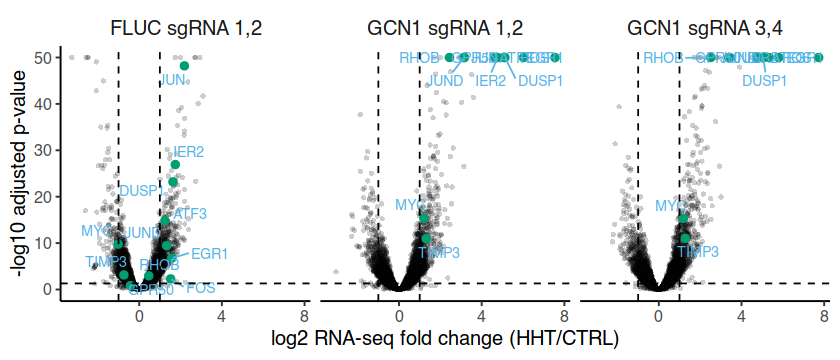

In [4]:
options(repr.plot.width = 7, repr.plot.height = 3)

plot_data <- lfc %>% 
  filter(compare %in% c("sgfluc_1_2.6hvs0h", "sggcn1_1_2.6hvs0h", "sggcn1_3_4.6hvs0h")) %>%
  mutate(compare = str_extract(compare, "^[^\\.]+")) %>%
  mutate(compare = str_replace(compare, "sgfluc_1_2", "FLUC sgRNA 1,2")) %>%
  mutate(compare = str_replace(compare, "sggcn1_1_2", "GCN1 sgRNA 1,2")) %>%
  mutate(compare = str_replace(compare, "sggcn1_3_4", "GCN1 sgRNA 3,4")) %>%
  mutate(padj = if_else(padj < 1e-50, 1e-50, padj)) %>% 
  select(compare, padj, lfc, gene_id, gene_name, baseMean, lfcSE) %>% 
  filter(!is.na(gene_name))

subset_data <- plot_data %>% 
  filter(gene_name %in% gene_subset)

plot_data %>% 
  ggplot(aes(x = lfc, y = -log10(padj))) +
  facet_wrap(~compare, ncol = 3) +
  geom_point(alpha = 0.2, stroke = NA) +
  geom_point(data = subset_data, color = cbPalette[4], size = 2) +
  # scale_y_continuous(limits = c(0, 60)) +
  ggrepel::geom_text_repel(data = subset_data, aes(label = gene_name), color = cbPalette[3], size = 3, max.overlaps = Inf) +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
  geom_vline(xintercept = c(-1, 1), linetype = "dashed") +
  labs(x = "log2 RNA-seq fold change (HHT/CTRL)", y = "-log10 adjusted p-value")

ggsave("../figures/volcano_plot_hht_treatment_padj_vs_lfc.pdf", width = 7, height = 3)

## Scatter plot of harringtonine fold changes between sgGCN1 and sgFLUC

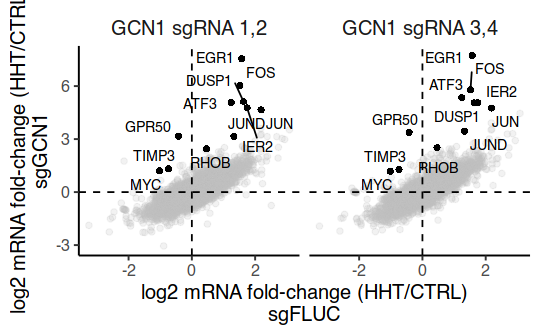

In [63]:
options(repr.plot.width = 4.5, repr.plot.height = 2.8)
plot_data_2 <- plot_data %>% 
  # filter(padj < 0.05) %>%
  mutate(lfc = if_else(lfc < -5, -5, lfc)) %>%
  # mutate(lfc = if_else(lfc > 5, 5, lfc)) %>%
  group_by(gene_id) %>% 
  filter(dplyr::n() == 3) %>%
  mutate(lfc_ctrl = lfc[compare == "FLUC sgRNA 1,2"]) %>% 
  ungroup() %>% 
  filter(compare != "FLUC sgRNA 1,2")

subset_data_2 <- plot_data_2 %>% 
  filter(gene_name %in% gene_subset)


plot_data_2 %>%
  ggplot(aes(x = lfc_ctrl, y = lfc)) +
  facet_wrap(~compare, ncol = 2) +
  geom_point(alpha = 0.2, color = "grey") +
  geom_point(data = subset_data_2, stroke = NA, size = 2, color = "black") +
  ggrepel::geom_text_repel(data = subset_data_2, aes(label = gene_name), color = "black", size = 3, max.overlaps = Inf) +
  # geom_abline(slope = 1, linetype = "dashed") +
  geom_hline(yintercept = 0, linetype = "dashed") +
  geom_vline(xintercept = 0, linetype = "dashed") +
  labs(x = "log2 mRNA fold-change (HHT/CTRL)\nsgFLUC", y = "log2 mRNA fold-change (HHT/CTRL)\nsgGCN1")

ggsave("../figures/scatter_plot_hht_treatment_gcn1_vs_fluc.pdf", width = 4.5, height = 2.8)

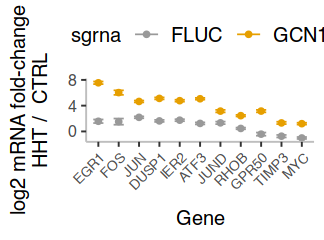

In [16]:
options(repr.plot.width = 2.7, repr.plot.height = 2)

plot_data <- lfc %>% 
  filter(compare %in% c("sgfluc_1_2.6hvs0h", "sggcn1_1_2.6hvs0h", "sggcn1_3_4.6hvs0h")) %>%
  mutate(compare = str_extract(compare, "^[^\\.]+")) %>%
  mutate(compare = str_replace(compare, "sgfluc_1_2", "FLUC")) %>%
  mutate(compare = str_replace(compare, "sggcn1_1_2", "GCN1_1_2")) %>%
  mutate(compare = str_replace(compare, "sggcn1_3_4", "GCN1_3_4")) %>%
  filter(compare != "GCN1_3_4") %>% 
  mutate(sgrna = str_replace(compare, "GCN1_1_2", "GCN1")) %>%
  select(sgrna, padj, lfc, gene_id, gene_name, baseMean, lfcSE) %>% 
  filter(gene_name %in% gene_subset) %>% 
  group_by(gene_name) %>% 
  mutate(order = sum(lfc)) %>% 
  ungroup() %>% 
  mutate(gene_name = fct_reorder(gene_name, -order))

plot_data %>% 
  ggplot(aes(x = gene_name, y = lfc, ymin = lfc - lfcSE, ymax = lfc + lfcSE, color = sgrna)) +
  geom_point() +
  geom_errorbar(width = 0.5) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 8.5), legend.position = "top") +
  # geom_hline(yintercept = 0, linetype = "dashed") +
  scale_y_continuous(breaks = c(0,4,8)) +
  labs(y = "log2 mRNA fold-change\nHHT /  CTRL", x = "Gene")

ggsave("../figures/ieg_alone_plot_hht_treatment_gcn1_vs_fluc.pdf", width = 2.7, height = 2)

## Scatter plot of harringtonine + GCN1 KO interaction effect for two different GCN1 sgRNA pairs

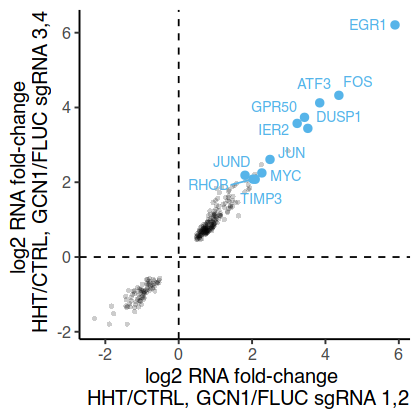

In [ ]:
options(repr.plot.width = 3.5, repr.plot.height = 3.5)

plot_data <- lfc %>% 
  filter(compare %in% c("sggcn1_1_2.6h.interaction", "sggcn1_3_4.6h.interaction")) %>%
  mutate(compare = str_extract(compare, "^[^\\.]+")) %>%
  select(compare, padj, lfc, gene_id, gene_name, baseMean) %>% 
  filter(padj < 0.05) %>% 
  select(-padj) %>% 
  pivot_wider(names_from = compare, values_from = lfc) %>% 
  drop_na() %>%
  mutate(avg_effect_hht_gcn1 = round((sggcn1_1_2 + sggcn1_3_4)/2, 2)) %>% 
  arrange(desc(avg_effect_hht_gcn1)) %>%
  write_csv("../tables/sggcn1_3_4_vs_sggcn1_1_2.6h.interaction.csv")


subset_data <- plot_data %>% 
  filter(gene_name %in% gene_subset)

plot_data %>% 
  ggplot(aes(x = sggcn1_1_2, y = sggcn1_3_4)) +
  geom_point(alpha = 0.2, stroke = NA) +
  geom_point(data = subset_data, color = cbPalette[3], size = 2) +
  ggrepel::geom_text_repel(data = subset_data, aes(label = gene_name), color = cbPalette[3], size = 3) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  geom_vline(xintercept = 0, linetype = "dashed") +
  labs(x = "log2 RNA fold-change \n HHT/CTRL, GCN1/FLUC sgRNA 1,2",
       y = "log2 RNA fold-change \n HHT/CTRL, GCN1/FLUC sgRNA 3,4")

ggsave("../figures/interaction_hht_treatment_sggcn1_12_vs_34.pdf", width = 3.5, height = 3.5)

In [ ]:
gcn1_hht_interaction_data <- read_csv("../tables/sggcn1_3_4_vs_sggcn1_1_2.6h.interaction.csv", show_col_types = F) %>%
  print()

# A tibble: 267 × 6
   gene_id         gene_name baseMean sggcn1_1_2 sggcn1_3_4 avg_effect_hht_gcn1
   <chr>           <chr>        <dbl>      <dbl>      <dbl>               <dbl>
 1 ENSG00000120738 EGR1        7360.        5.90       6.21                6.05
 2 ENSG00000170345 FOS          791.        4.37       4.32                4.35
 3 ENSG00000162772 ATF3        6515.        3.84       4.12                3.98
 4 ENSG00000102195 GPR50        986.        3.43       3.74                3.58
 5 ENSG00000120129 DUSP1       3808.        3.52       3.44                3.48
 6 ENSG00000160888 IER2        6846.        3.23       3.57                3.4 
 7 ENSG00000198576 ARC          159.        2.98       2.84                2.91
 8 ENSG00000177606 JUN        23358.        2.49       2.61                2.55
 9 ENSG00000213626 LBH           97.4       2.25       2.47                2.36
10 ENSG00000136997 MYC         1875.        2.27       2.25                2.26
# … with 257 more ro

## Extract annotations and sequences for GCN1+HHT selective transcripts

### Read ENSEMBL transcript annotations

In [ ]:
ensembl <- read_gff("../data/ensembl/Homo_sapiens.GRCh38.108.gtf")

## Extract MANE transcript annotations for top 12 GCN1+HHT hits + 3 controls

In [ ]:
gcn1_hht_hit_tx <- ensembl %>%
  filter(str_detect(tag, "MANE_Select")) %>%
  filter(type %in% c("CDS", "five_prime_utr", "three_prime_utr")) %>%
  filter(gene_id %in% gcn1_hht_interaction_data$gene_id[1:12] | gene_name %in% c("EEF1A1", "GAPDH", "ACTB")) %>%
  as_tibble() %>%
  group_by(gene_id) %>%
  arrange(start) %>%
  mutate(order = if_else(strand == "+", seq(1, dplyr::n()), seq(dplyr::n(), 1))) %>%
  arrange(order) %>%
  ungroup() %>%
  mutate(seqnames = paste0("chr", seqnames)) %>%
  GRanges() %>%
  print()

### Extract UTR5 sequences

In [ ]:
utr5_seq <- gcn1_hht_hit_tx  %>%
  filter(type == "five_prime_utr") %>%
  split(.$gene_name) %>%
  GenomicFeatures::extractTranscriptSeqs(BSgenome.Hsapiens.UCSC.hg38::BSgenome.Hsapiens.UCSC.hg38, .)

### Extract CDS

In [ ]:
cds_seq <- gcn1_hht_hit_tx  %>%
  filter(type == "CDS") %>%
  split(.$gene_name) %>%
  GenomicFeatures::extractTranscriptSeqs(BSgenome.Hsapiens.UCSC.hg38::BSgenome.Hsapiens.UCSC.hg38, .)

### Concatenate UTR5 and first 150 nt of CDS and write to file

In [ ]:
utr5_cds100_seq <- cds_seq %>% 
  Biostrings::subseq(start = 1, width = 150) %>%
  Biostrings::xscat(utr5_seq, .) %>%
  setNames(names(utr5_seq))
  
utr5_cds100_seq %>%
  Biostrings::writeXStringSet("../annotations/cloned_utr5_and_cds_100.fasta")

### Check for NotI that we need for mix-n-match cloning with guides. We will mutate out this site during cloning

Luckily both sites are close to the 5' end, so we can use a bridge primer to mutate them out

In [ ]:
utr5_cds100_seq  %>%
  Biostrings::vmatchPattern(Biostrings::DNAString("GCGGCCGC"), .) %>%
  unlist() %>%
  as.data.frame()